## ConvNet

To refactor layers, it's useful to have a `Lambda` layer that can take a basic function and convert it to a layer you can put in `nn.Sequential`.

NB: if you use a Lambda layer with a lambda function, your model won't pickle so you won't be able to save it with PyTorch. So it's best to give a name to the function you're using inside your Lambda (like flatten below).

In [ ]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

In [ ]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

With the `AdaptiveAvgPool`, this model can now work on any size input:

In [ ]:
nfs = [8,16,32,32]

In [ ]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

## Generalized ReLU

Now let's use our model with a generalized ReLU that can be shifted and with maximum value.

In [ ]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [ ]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.54654125, tensor(0.8278, device='cuda:0')]
valid: [0.15122969970703126, tensor(0.9572, device='cuda:0')]


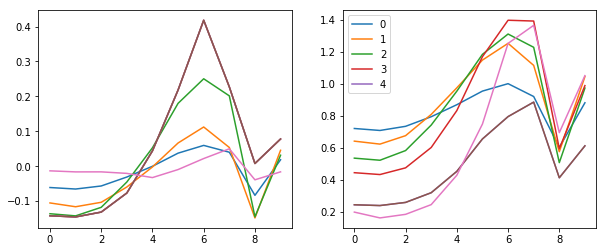

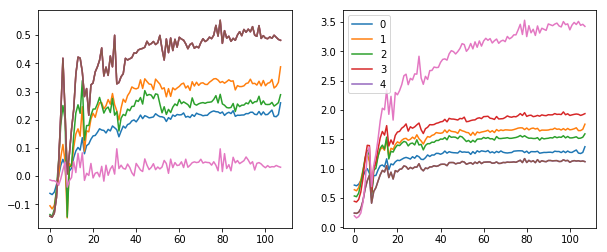

In [ ]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

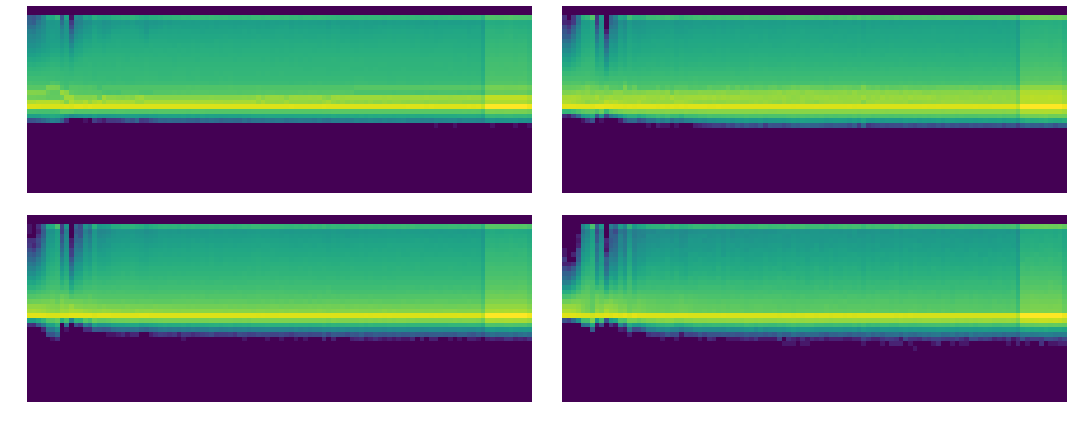

In [ ]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [ ]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 

In [ ]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [ ]:
run.fit(8, learn)

train: [1.177220859375, tensor(0.6270, device='cuda:0')]
valid: [0.331805712890625, tensor(0.8985, device='cuda:0')]
train: [0.3674151171875, tensor(0.8885, device='cuda:0')]
valid: [0.394902099609375, tensor(0.8691, device='cuda:0')]
train: [0.29181142578125, tensor(0.9135, device='cuda:0')]
valid: [0.12695498046875, tensor(0.9642, device='cuda:0')]
train: [0.11358849609375, tensor(0.9647, device='cuda:0')]
valid: [0.1171941650390625, tensor(0.9657, device='cuda:0')]
train: [0.0813043896484375, tensor(0.9754, device='cuda:0')]
valid: [0.102300390625, tensor(0.9715, device='cuda:0')]
train: [0.057199677734375, tensor(0.9825, device='cuda:0')]
valid: [0.07670272216796875, tensor(0.9786, device='cuda:0')]
train: [0.04207271484375, tensor(0.9870, device='cuda:0')]
valid: [0.06070926513671875, tensor(0.9811, device='cuda:0')]
train: [0.03412069091796875, tensor(0.9899, device='cuda:0')]
valid: [0.06048909301757813, tensor(0.9826, device='cuda:0')]


Uniform init may provide more useful initial weights (normal distribution puts a lot of them at 0).

In [ ]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))